In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [87]:
#часть с ответами
df_train = pd.read_csv('train.csv',
                       sep=',', encoding='utf8')
#часть без ответов
df_test = pd.read_csv('test.csv',
                       sep=',', encoding='utf8')

In [88]:
# объединим и пометим сеты
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'
df = df_train.append(df_test).reset_index(drop=True)

c:\users\yurki\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [82]:
df_test1_preproc.head()

,age,campaign,cons.conf.idx,cons.price.idx,duration,emp.var.rate,euribor3m,nr.employed,pdays,previous,...,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
24712,57,1,-46.2,92.893,371,-1.8,1.299,5099.1,999,1,...,0,1,0,0,1,1,0,1,0,0
24713,55,2,-36.4,93.994,285,1.1,4.860,5191.0,999,0,...,0,0,1,1,0,0,1,0,1,0
24714,33,1,-46.2,92.893,52,-1.8,1.313,5099.1,999,1,...,0,1,0,1,0,1,0,1,0,0
24715,36,4,-41.8,94.465,355,1.4,4.967,5228.1,999,0,...,0,1,0,1,0,0,1,0,1,0
24716,27,2,-42.7,93.918,189,1.4,4.963,5228.1,999,0,...,0,0,1,1,0,1,0,0,1,0


In [81]:
#все таки нужно объединить тест и трейн, чтобы были одинаковые поля
#обучить модель на тесте , а потом предсказать
df_test1_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16476 entries, 24712 to 41187
Data columns (total 30 columns):
age                     16476 non-null int64
campaign                16476 non-null int64
cons.conf.idx           16476 non-null float64
cons.price.idx          16476 non-null float64
duration                16476 non-null int64
emp.var.rate            16476 non-null float64
euribor3m               16476 non-null float64
nr.employed             16476 non-null float64
pdays                   16476 non-null int64
previous                16476 non-null int64
target                  16476 non-null float64
job_employed            16476 non-null uint8
job_unemployed          16476 non-null uint8
marital_divorced        16476 non-null uint8
marital_married         16476 non-null uint8
marital_single          16476 non-null uint8
education_high          16476 non-null uint8
education_illiterate    16476 non-null uint8
education_school        16476 non-null uint8
default_no          

In [ ]:
_id - идентификатор человека
age - возраст
job - тип работы ("admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
marital - семейное положение ("divorced" (разведенный и овдовевший),"married","single","unknown")
education - уровень образования ("basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
default - есть ли дефолт по кредиту ("no","yes","unknown")
housing - есть ли кредит на жилье ("no","yes","unknown")
loan - есть ли персональный кредит ("no","yes","unknown")
contact - контактный тип связи ("cellular","telephone")
month - последний контактный месяц года ("jan", "feb", "mar", ..., "nov", "dec")
day_of_week - последний контактный день недели ("mon","tue","wed","thu","fri")
duration - длительность последнего контакта в секундах. (Важное замечание: этот атрибут сильно влияет на таргет (например, если длительность - 0 сек., то таргет - 0). Тем не менее, продолжительность не известна до выполнения вызова.
campaign - количество контактов, выполненных для этого клиента в рамках текущей маркетинговой кампании (включая последний контакт)
pdays - количество дней прошедших последнего контакта с клиентом с предыдущей маркетинговой кампании (999 означает, что ранее с клиентом не контактировали)
previous - количество контактов, выполненных до текущей маркетинговой кампании для этого клиента
poutcome - результат предыдущей маркетинговой кампании ("failure","nonexistent","success")
# ниже приведены показатели окружающей среды и банка
emp.var.rate - изменение уровня занятости (квартальный показатель)
cons.price.idx - индекс потребительских цен (ежемесячный показатель)
cons.conf.idx - индекс доверия потребителя (ежемесячный показатель)
euribor3m - курс Euribor (ежедневный показатель)
nr.employed - количество сотрудников (квартальный показатель)
target - целевая переменная (таргет) - согласился ли клиент на вклад (депозит)

In [89]:
def preproc_df(df_input):
    df_loc = df_input.copy()
    #Заменяем unknown на NaN
    df_loc = df_loc.replace("unknown", np.nan)
    #Заменяем пропуска на моду
    df_loc = df_loc.fillna(df_loc.mode().loc[0])
    
    def proc_job(i):
        if i in ["unemployed","student","retired","housemaid"]:
            i = "unemployed"
        else: i = "employed"    
          
     #   if (i != "unknown") & (i != "unemployed"):
     #       i = "employed"
           
        return i
    df_loc['job'] = df_loc['job'].map(proc_job)
    
    def proc_education(i):
        if i in ["basic.4y","basic.6y","basic.9y"]:
            i = "school"
        elif i in ["high.school","professional.course","university.degree"]:
            i = "high"
        return i
    df_loc['education'] = df_loc['education'].map(proc_education)
    df_loc = df_loc.drop(['month','day_of_week','_id'], axis=1)
    
    df_loc = pd.get_dummies(df_loc, columns=['job','marital', 'education','default','housing','loan','contact','poutcome'])
    
    return df_loc

In [90]:
df_train1 = ''
df_train1 = df.pipe(preproc_df)

In [60]:
df_train1.columns

Index(['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration',
       'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays', 'previous',
       'sample', 'target', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_management', 'job_self-employed', 'job_services', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_high', 'education_illiterate',
       'education_school', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')

In [64]:
df_train1_preproc = df_train1.query('sample == "train"').drop(['sample'], axis=1)
df_test1_preproc = df_train1.query('sample == "test"').drop(['sample'], axis=1)


In [91]:
X_train = df_train1_preproc.drop(['target'], axis=1)
y_train = df_train1_preproc['target']
X_test = df_test1_preproc.drop(['target'], axis=1)
y_test = df_test1_preproc['target']

In [92]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = \
    train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#tree = DecisionTreeClassifier()
model = LogisticRegression()
model.fit(X_train1, y_train1)

c:\users\yurki\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [68]:
predict = model.predict(X_test1)

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('precision', precision_score(y_test1, predict))
print('recall', recall_score(y_test1, predict))
print('accuracy', accuracy_score(y_test1, predict))

precision 0.6680244399185336
recall 0.38908659549228947
accuracy 0.9085513892635554


In [95]:
#Делаем кросс-валидацию и считаем средний roc_auc
from sklearn.model_selection import cross_val_score

cross_val_score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=10)
print("Средний roc_auc:")
print(cross_val_score.mean())

c:\users\yurki\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\yurki\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\yurki\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\yurki\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\yurki\appdata\local\programs\python\python37\lib\si

Средний roc_auc:
0.9208590229232371


In [96]:
from sklearn.metrics import roc_auc_score, roc_curve
predic_proba_model = model.predict_proba(X_test1)
print('roc_auc', roc_auc_score(y_test1, predic_proba_model[:,1]))

roc_auc 0.9252215917635146


(-0.01, 1.01)

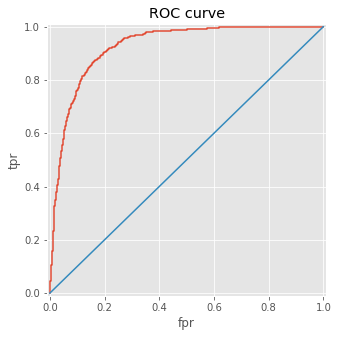

In [72]:
#Строим ROC кривую
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test1, predic_proba_model[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [73]:
predict_test = model.predict(X_test)

In [74]:
predict_test

array([0., 0., 0., ..., 0., 0., 0.])

In [75]:
se = pd.Series(predict_test)
df_test['target'] = se.values

In [76]:
df_results = df_test[['_id','target']]

In [78]:
df_results.to_csv('result5.csv',sep=',', encoding='utf8')